In [110]:
# Required Python Packages
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from numpy import mean
from collections import Counter

In [111]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [112]:
%matplotlib inline

In [113]:
# Plotting packages
%matplotlib inline
plt.rcParams['figure.figsize'] = (4, 2)
plt.rcParams['figure.dpi'] = 170
mpl.rc('xtick', labelsize = 6) 
mpl.rc('ytick', labelsize = 6)
plt.rcParams.update({'font.size': 6})

In [114]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [115]:
path = "/Users/frederikluneborgholmjeppesen/Documents/Universitetet/3. år/Bachelorprojektet/MotorRegisterData-main/"
choice_data_subset = pd.read_excel(path + 'choice_data_subset.xlsx')
choice_data_subset['Fuel'].replace(['El', 'Benzin', 'Diesel'], [0, 1, 2], inplace = True)
choice_data_subset

,Year,Shares,Fuel,Weight (kg),Engine effect (kW),Prices (2015-DKK),key,Size segment,No. of registrations,Horsepower,Cost/km (DKK)
0,2006,0.002156,1,1820,108.0,403349.2991,toyota-avensis-2006-Benzin,Small,5428,139.307692,0.813669
1,2006,0.002137,2,2170,103.0,378504.6729,volkswagen-passat-2006-Diesel,Large,5378,128.333333,0.681879
2,2006,0.001795,1,1425,43.0,134344.6262,renault-clio-2006-Benzin,Small,4518,60.000000,0.677246
3,2006,0.001750,1,1475,68.0,163536.2150,suzuki-swift-2006-Benzin,Small,4406,94.000000,0.734416
4,2006,0.001487,1,1590,48.0,150287.3832,fiat-punto-2006-Benzin,Small,3743,63.888889,0.689634
...,...,...,...,...,...,...,...,...,...,...,...
2785,2020,0.000013,2,2850,210.0,977674.0812,volkswagen-touareg-2020-Diesel,Large,35,286.000000,0.643713
2786,2020,0.000300,1,1930,110.0,303593.8104,volkswagen-golf-sportsvan-2020-Benzin,Large,818,150.000000,0.583654
2787,2020,0.000136,0,1530,61.0,153689.5551,volkswagen-up-2020-El,Small,370,61.222222,0.306765
2788,2020,0.001088,1,1760,85.0,263941.9729,volkswagen-t-cross-2020-Benzin,Small,2969,115.000000,0.541964


In [116]:
print("Amount of cars divided in fuel:\n", "El =", Counter(y)[0], ", Benzin =", Counter(y)[1], ", Diesel =", Counter(y)[2])

Amount of cars divided in fuel:
 El = 84 , Benzin = 1586 , Diesel = 1120


interactive(children=(FloatSlider(value=0.0, description='tax', max=1.0), Checkbox(value=False, description='o…

<function __main__.f(tax, only_tax_el)>

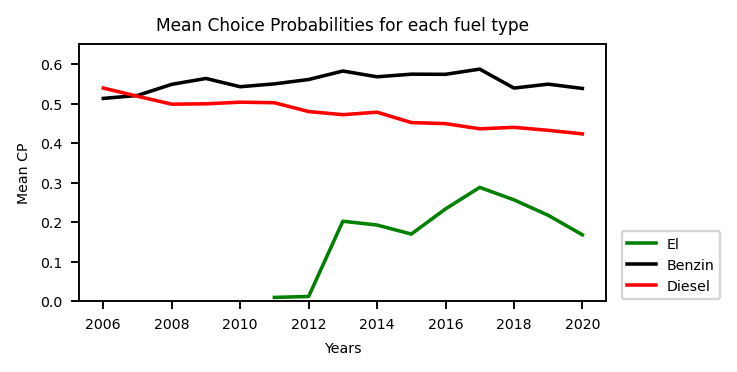

In [119]:
def f(tax, only_tax_el):
    y = choice_data_subset.iloc[:, 2]
    X = choice_data_subset[['Prices (2015-DKK)', 'Weight (kg)', 'Engine effect (kW)', 'Cost/km (DKK)', 'Horsepower']]
    X = X.astype(float)
    
    if only_tax_el == True:
        for i in range(0, choice_data_subset.shape[0]):
            if choice_data_subset.Fuel[i] == 0:
                choice_data_subset.iloc[i, 5] = (1 + tax) * choice_data_subset.iloc[i, 5]
    else:
        tax_prices = (1 + tax) * X['Prices (2015-DKK)']
        X['Prices (2015-DKK)'] = tax_prices
    
    model = LogisticRegression(multi_class = 'auto', solver = 'lbfgs', tol = 1e-8, max_iter = 10000, penalty = 'l2', C = 1.0).fit(X, y)
    probabilities = model.predict_proba(X)
    #print(probabilities.shape)
    
    cp_el = []
    cp_benzin = []
    cp_diesel = []
    
    for i, choice in enumerate(y):
        if choice == 0:
            cp_el.append(probabilities[i, choice])
        
        elif choice == 1:
            cp_benzin.append(probabilities[i, choice])
        
        else:
            cp_diesel.append(probabilities[i, choice])
    
    choice_data_el_subset = choice_data_subset[['Year', 'Fuel']].set_index(['Fuel']).loc[0]
    #print(choice_data_el_subset)
    choice_data_el_subset = choice_data_el_subset.assign(cp_el = cp_el)
    #print(choice_data_el_subset)
    choice_data_el_subset = choice_data_el_subset.groupby('Year')['cp_el'].mean()
    #print(choice_data_el_subset)
    
    choice_data_benzin_subset = choice_data_subset[['Year', 'Fuel']].set_index(['Fuel']).loc[1]
    choice_data_benzin_subset = choice_data_benzin_subset.assign(cp_benzin = cp_benzin)
    choice_data_benzin_subset = choice_data_benzin_subset.groupby('Year')['cp_benzin'].mean()
    
    choice_data_diesel_subset = choice_data_subset[['Year', 'Fuel']].set_index(['Fuel']).loc[2]
    choice_data_diesel_subset = choice_data_diesel_subset.assign(cp_diesel = cp_diesel)
    choice_data_diesel_subset = choice_data_diesel_subset.groupby('Year')['cp_diesel'].mean()
    
    years_el = choice_data_subset[['Year', 'Fuel']].set_index(['Fuel']).loc[0].drop_duplicates()
    years_benzin = choice_data_subset[['Year', 'Fuel']].set_index(['Fuel']).loc[1].drop_duplicates()
    years_diesel = choice_data_subset[['Year', 'Fuel']].set_index(['Fuel']).loc[2].drop_duplicates()

    plt.plot(np.array(years_el), np.array(choice_data_el_subset), c = 'green', label ="El")
    plt.plot(np.array(years_benzin), np.array(choice_data_benzin_subset), c = 'black', label ="Benzin")    
    plt.plot(np.array(years_diesel), np.array(choice_data_diesel_subset), c = 'red', label ="Diesel")
    
    plt.ylim(0, 0.65)
    plt.title('Mean Choice Probabilities for each fuel type')
    plt.xlabel("Years")
    plt.ylabel("Mean CP")
    plt.legend(bbox_to_anchor = (1.23, 0.3), ncol = 1)
        
interact(f, tax = (0, 1, 0.10), only_tax_el = False)